In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import itertools
import random
import operator # TODO: check this library
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

TODO: - Only 3 haplotypes with non-zero probability to obtain a unique solution
      - Think of a new query for the posterior to get a distribution over probability (frequenticies)
	  - Generate 200 or 300 genotypes to see if convergence improves (we should not need that many)

In [40]:
#32 Haplotypes
#5 placings in the haplotype (2⁵ = 32)
#100 genotypes

haplotypes = list(map(list, itertools.product([0, 1], repeat=5)))
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

haplotypes_prob_synth = [
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.32366666666666666, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,   
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.32366666666666666, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.00100000000000000,
    0.00100000000000000, 0.00100000000000000, 0.00100000000000000, 0.32366666666666666
]

In [41]:
# NOTE: We try a simpler version of the problem with all probability
# mass concentrated in 3 haplotypes
haplotypesProb=haplotypes_prob_synth

In [42]:
# NOTE: This is a dict to store the number of haplotypes drawn from the probabilities above
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

In [43]:
# NOTE: This code snippet samples 100 genotypes by sampling haplotypes with the probabilities above
#       I suppose the goal is to recover the probabilities above
genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []} # NOTE: added by Raúl
# seeds not working...
np.random.seed(2023)
random.seed(2023)
for i in range(100):
    h1 = np.random.choice(np.arange(32), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    h2 = np.random.choice(np.arange(32), p=haplotypesProb) # samples one haplotype (from 0 to 31) with probabilities above
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2]))) # combines them to form a genotype
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); # NOTE: added by Raúl
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] +1 # keeps count of sampled haplotypes 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] +1 # keeps count of sampled haplotypes 
df = pd.DataFrame(data=d)

In [44]:
df

,h_1,h_2,g
0,"[0, 0, 1, 0, 1]","[1, 1, 1, 1, 1]","[1, 1, 2, 1, 2]"
1,"[1, 0, 0, 1, 0]","[0, 0, 1, 0, 1]","[1, 0, 1, 1, 1]"
2,"[0, 0, 1, 0, 1]","[1, 0, 0, 1, 0]","[1, 0, 1, 1, 1]"
3,"[0, 0, 1, 0, 1]","[1, 1, 1, 1, 1]","[1, 1, 2, 1, 2]"
4,"[1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[2, 0, 0, 2, 0]"
...,...,...,...
95,"[0, 0, 1, 0, 1]","[0, 0, 1, 0, 1]","[0, 0, 2, 0, 2]"
96,"[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[2, 2, 2, 2, 2]"
97,"[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[2, 2, 2, 2, 2]"
98,"[1, 0, 0, 1, 0]","[1, 1, 1, 1, 1]","[2, 1, 1, 2, 1]"


In [45]:
haplotypesnumber

{'[0, 0, 0, 0, 0]': 0,
 '[0, 0, 0, 0, 1]': 0,
 '[0, 0, 0, 1, 0]': 0,
 '[0, 0, 0, 1, 1]': 0,
 '[0, 0, 1, 0, 0]': 0,
 '[0, 0, 1, 0, 1]': 57,
 '[0, 0, 1, 1, 0]': 0,
 '[0, 0, 1, 1, 1]': 0,
 '[0, 1, 0, 0, 0]': 1,
 '[0, 1, 0, 0, 1]': 1,
 '[0, 1, 0, 1, 0]': 0,
 '[0, 1, 0, 1, 1]': 0,
 '[0, 1, 1, 0, 0]': 0,
 '[0, 1, 1, 0, 1]': 0,
 '[0, 1, 1, 1, 0]': 0,
 '[0, 1, 1, 1, 1]': 2,
 '[1, 0, 0, 0, 0]': 1,
 '[1, 0, 0, 0, 1]': 0,
 '[1, 0, 0, 1, 0]': 71,
 '[1, 0, 0, 1, 1]': 0,
 '[1, 0, 1, 0, 0]': 0,
 '[1, 0, 1, 0, 1]': 0,
 '[1, 0, 1, 1, 0]': 0,
 '[1, 0, 1, 1, 1]': 0,
 '[1, 1, 0, 0, 0]': 0,
 '[1, 1, 0, 0, 1]': 0,
 '[1, 1, 0, 1, 0]': 1,
 '[1, 1, 0, 1, 1]': 1,
 '[1, 1, 1, 0, 0]': 0,
 '[1, 1, 1, 0, 1]': 0,
 '[1, 1, 1, 1, 0]': 1,
 '[1, 1, 1, 1, 1]': 64}

In [46]:
# Assumption, all bit-vectors are of the same size
num_bits = 2
num_vars = 5*100*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
for i in range(num_vars):
    g.add(ULE(x[i],1)) # Each BitVec is in {0,1}

for i in range(100): # iterate over all genotypes
    for j in range(5): # iterate over all bits of the BitVec
        g.add(x[i*10+j] + x[i*10+j+5] == genotypes[i][j])

In [47]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4)

[x7600 = True,
 x6310 = True,
 x790 = False,
 x3910 = True,
 x1800 = True,
 x7680 = False,
 x2000 = True,
 x1320 = True,
 x7470 = False,
 x5270 = False,
 x6000 = True,
 x5610 = True,
 x7700 = True,
 x8760 = False,
 x9820 = True,
 x980 = False,
 x6040 = True,
 x880 = False,
 x2260 = False,
 x2420 = True,
 x8740 = True,
 x380 = False,
 x6380 = False,
 x4290 = False,
 x2670 = False,
 x9440 = True,
 x8920 = True,
 x6580 = False,
 x8670 = False,
 x7630 = True,
 x9940 = True,
 x2660 = False,
 x6970 = False,
 x9010 = True,
 x1180 = False,
 x280 = False,
 x4980 = False,
 x5390 = False,
 x2480 = False,
 x8940 = True,
 x2530 = True,
 x5170 = False,
 x1470 = False,
 x5070 = False,
 x8620 = True,
 x8720 = True,
 x4930 = True,
 x2440 = True,
 x8960 = False,
 x4820 = True,
 x9160 = False,
 x2500 = True,
 x780 = False,
 x6080 = False,
 x8570 = False,
 x9420 = True,
 x830 = True,
 x7620 = True,
 x4810 = True,
 x9890 = False,
 x4670 = False,
 x4300 = True,
 x4640 = True,
 x7540 = True,
 x220 = True,
 x

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4523/4523/0
independent support size:  	0
clauses (all/long/binary/unit): 9970/4092/4570/1308
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5118 MB

STAGE #1: Build the initial partial assignments



time elapsed: 60.8436s


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5118 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE




variables (total / active / free)	4523/4523/0
clauses (removed) 		9970 (0)
decisions 				215
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1308
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache size     	20253420	
bytes cache (overall) 	20253420
bytes cache (infra / comps) 20234408/19012	
bytes pure comp data (curr)    5140
bytes pure comp data (overall) 5140
bytes cache with sysoverh (curr)    32920
bytes cache with sysoverh (overall) 32920
cache (stores / hits) 			217/0
cache miss rate 		100%
avg. variable count (stores / hits) 	46.6406/0


# solutions 
52656145834278593348959013841835216159447547700274555627155488768

# END

time: 121.434s


Total Sampler Execution Time: 121.434s

#START_HEADER
start_time,Thu Dec 14 15:01:32 2023
formula_file,spur_input/z3_problem.cnf
num_vars,4523
independent_support_size,0
num_clauses,9970
tot_num_models,52656145834278593348959013841835216159447547700274555627155488768
max_component_split_depth,1
max_branch_

TODO: Determine the right queries for the posterior

We should determine the probability of each haplotype?

Or should we retreive the invidivual haplotypes for each record?

In [48]:
var_names= ['x0','x1','x2','x3','x4']
trace.posterior[var_names].sel(chain=3,draw=range(30000-10,30000))

<xarray.Dataset>
Dimensions:  (draw: 10)
Coordinates:
    chain    int64 3
  * draw     (draw) int64 29990 29991 29992 29993 ... 29996 29997 29998 29999
Data variables:
    x0       (draw) int64 0 0 0 0 0 0 1 0 1 1
    x1       (draw) int64 0 1 1 0 0 1 0 1 0 1
    x2       (draw) int64 1 1 1 1 1 1 1 1 1 1
    x3       (draw) int64 0 1 0 0 1 0 0 1 1 1
    x4       (draw) int64 1 1 1 1 1 1 1 1 1 1
Attributes:
    created_at:     2023-12-14T14:03:09.498186
    arviz_version:  0.15.1

In [49]:
trace.posterior[var_names].to_array().values.reshape(5,-1).T[-10:]

array([[0, 0, 1, 0, 1],
       [0, 1, 1, 1, 1],
       [0, 1, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [0, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [ ]:
haplo_var_vectors = [[f'x{i+j}' for j in range(5) ] for i in np.arange(0,num_vars,step=5)]
haplo_var_vectors

In [51]:
def __get_distinct_haplotype_counts(trace, var_names: list[str]):
    """
    Returns the count of each distinct sampled haplotype for the Bitvector specified by the variables in `var_names`
    Note: Try to reimplement this function more efficiently. The bottleneck seem to be the casting of integer lists to str
    """
    return np.unique(np.array([str(a).replace(" ", ", ") for a in trace.posterior[var_names].to_array().values.reshape(5,-1).T]), return_counts=True)

def get_count_haplotypes(trace, num_vars, haplotypes):
    """
    Returns a dictionary where keys are haplotypes and values are the counts of each haplotype in the trace.
    Note: It is computationally expensive due to the function `__get_distinct_haplotype_counts`.
    """
    # list of lists where each list contains the variables for each BitVector (to be used as indexes in the posterior trace)
    haplo_var_vectors = [[f'x{i+j}' for j in range(5) ] for i in np.arange(0,num_vars,step=5)]
    # list of pairs where the first element in each pair is list with
    # each distinct haplotype, and the second pair element is a list
    # with the counts of the corresponding haplotype
    counts_per_var_vector = [__get_distinct_haplotype_counts(trace, haplo_var_vector) for haplo_var_vector in haplo_var_vectors]
    # initilize a dict with distinct haplotypes as keys and values are counts of each haplotype (initially 0)
    haplotypesnumber_posterior = { str(haplotypes[i]): 0 for i in range(32) }
    # iterate over all haplotype counts for each BitVector, and add them to the dictionary above
    for i in counts_per_var_vector:
        num_distinct_haplotypes = len(i[0])
        for j in range(num_distinct_haplotypes):
            haplotypesnumber_posterior[i[0][j]] += i[1][j]
    # return dictionary with all counts
    return haplotypesnumber_posterior

In [52]:
haplotypesnumber_posterior = get_count_haplotypes(trace, num_vars, haplotypes)

In [14]:
## Data from previous run

# haplotypesnumber_posterior = {
#  '[0, 0, 0, 0, 0]': 247004,
#  '[0, 0, 0, 0, 1]': 607128,
#  '[0, 0, 0, 1, 0]': 307620,
#  '[0, 0, 0, 1, 1]': 818288,
#  '[0, 0, 1, 0, 0]': 412276,
#  '[0, 0, 1, 0, 1]': 1103424,
#  '[0, 0, 1, 1, 0]': 472740,
#  '[0, 0, 1, 1, 1]': 713544,
#  '[0, 1, 0, 0, 0]': 653180,
#  '[0, 1, 0, 0, 1]': 381460,
#  '[0, 1, 0, 1, 0]': 594260,
#  '[0, 1, 0, 1, 1]': 411860,
#  '[0, 1, 1, 0, 0]': 878104,
#  '[0, 1, 1, 0, 1]': 577520,
#  '[0, 1, 1, 1, 0]': 1294472,
#  '[0, 1, 1, 1, 1]': 727120,
#  '[1, 0, 0, 0, 0]': 759108,
#  '[1, 0, 0, 0, 1]': 578796,
#  '[1, 0, 0, 1, 0]': 1208096,
#  '[1, 0, 0, 1, 1]': 335244,
#  '[1, 0, 1, 0, 0]': 619504,
#  '[1, 0, 1, 0, 1]': 1373360,
#  '[1, 0, 1, 1, 0]': 411388,
#  '[1, 0, 1, 1, 1]': 352480,
#  '[1, 1, 0, 0, 0]': 1760908,
#  '[1, 1, 0, 0, 1]': 1373004,
#  '[1, 1, 0, 1, 0]': 531760,
#  '[1, 1, 0, 1, 1]': 472284,
#  '[1, 1, 1, 0, 0]': 1449520,
#  '[1, 1, 1, 0, 1]': 905704,
#  '[1, 1, 1, 1, 0]': 760060,
#  '[1, 1, 1, 1, 1]': 908784
#}

In [53]:
def normalize_haplotypes_posterior(haplo_num_posterior):
    """
    Takes as input a dict with haplotypes as keys and their counts and values.
    Returns a similar dict where values is the probability of each haplotype (frequentist)
    """
    total = sum([haplo_num_posterior[x] for x in list(haplo_num_posterior.keys())])
    return { x: haplo_num_posterior[x]/total  for x in list(haplo_num_posterior.keys())}

In [54]:
c = normalize_haplotypes_posterior(haplotypesnumber_posterior)
d = normalize_haplotypes_posterior(haplotypesnumber)

In [57]:
posterior_probs = [c[k] for k in c.keys()]
posterior_probs_sample = [d[k] for k in d.keys()]

In [59]:
df_p = pd.DataFrame(data={'MCMC+SAT': posterior_probs, 'population': haplotypesProb, 'sample': posterior_probs_sample})

In [71]:
df_p

,MCMC+SAT,population,sample
0,0.016812,0.001000,0.000
1,0.016905,0.001000,0.000
2,0.014358,0.001000,0.000
3,0.014326,0.001000,0.000
4,0.016296,0.001000,0.000
5,0.118926,0.323667,0.285
6,0.013682,0.001000,0.000
7,0.036259,0.001000,0.000
8,0.001887,0.001000,0.005
9,0.001877,0.001000,0.005


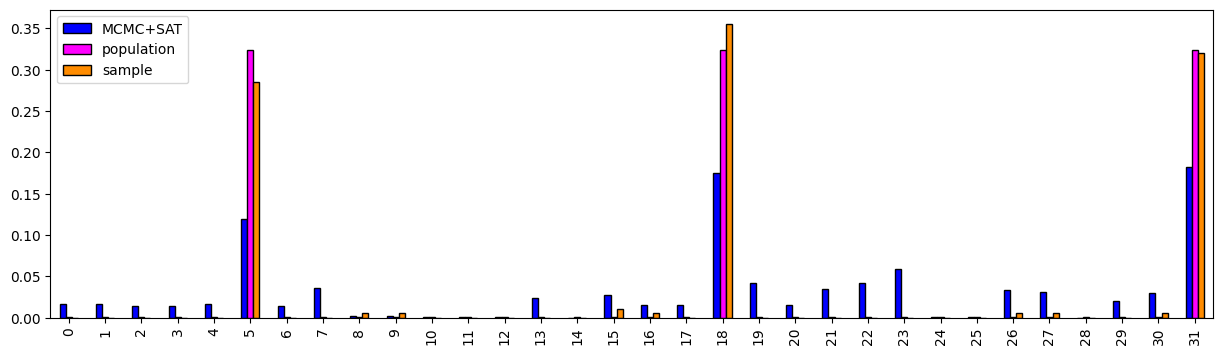

In [70]:
df_p.plot.bar(figsize=(15,4), color=['blue', 'fuchsia', 'darkorange'], edgecolor='black');
plt.savefig('haplo_mcmc_sat.png',dpi=150);

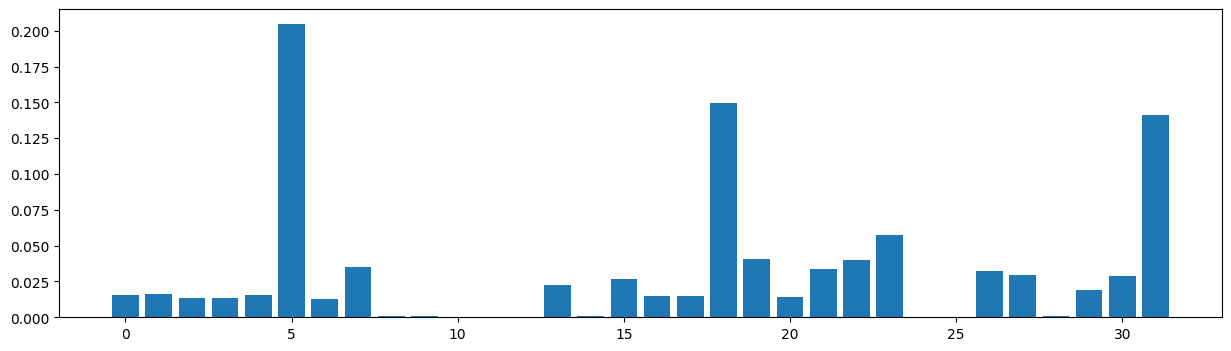

In [69]:
# comparing haplotype probabilities with original
fig, ax = plt.subplots(1,figsize=(15,4))
ax.bar(range(32), [abs(posterior_probs[i] - haplotypesProb[i]) for i in range(len(haplotypesProb))]);

In [25]:
[abs(posterior_probs[i] - haplotypesProb[i]) for i in range(len(haplotypesProb))]

[0.0046918333333333334,
 0.021297,
 0.0091375,
 0.06590466666666667,
 0.011497166666666668,
 0.044023999999999994,
 0.0150175,
 0.026731,
 0.05278416666666667,
 0.009747166666666668,
 0.018810833333333332,
 0.010060833333333333,
 0.03313766666666666,
 0.017743333333333333,
 0.04606366666666667,
 0.027396666666666666,
 0.024529499999999996,
 0.0179695,
 0.034662666666666675,
 0.0094014,
 0.022433666666666668,
 0.04277666666666667,
 0.012531166666666666,
 0.008546666666666668,
 0.0016288333333333294,
 0.0227915,
 0.01454666666666667,
 0.015357500000000001,
 0.02960333333333333,
 0.028519766666666557,
 0.018269166666666663,
 0.037134]

An attempt to use the posterior distribution to draw conclusions

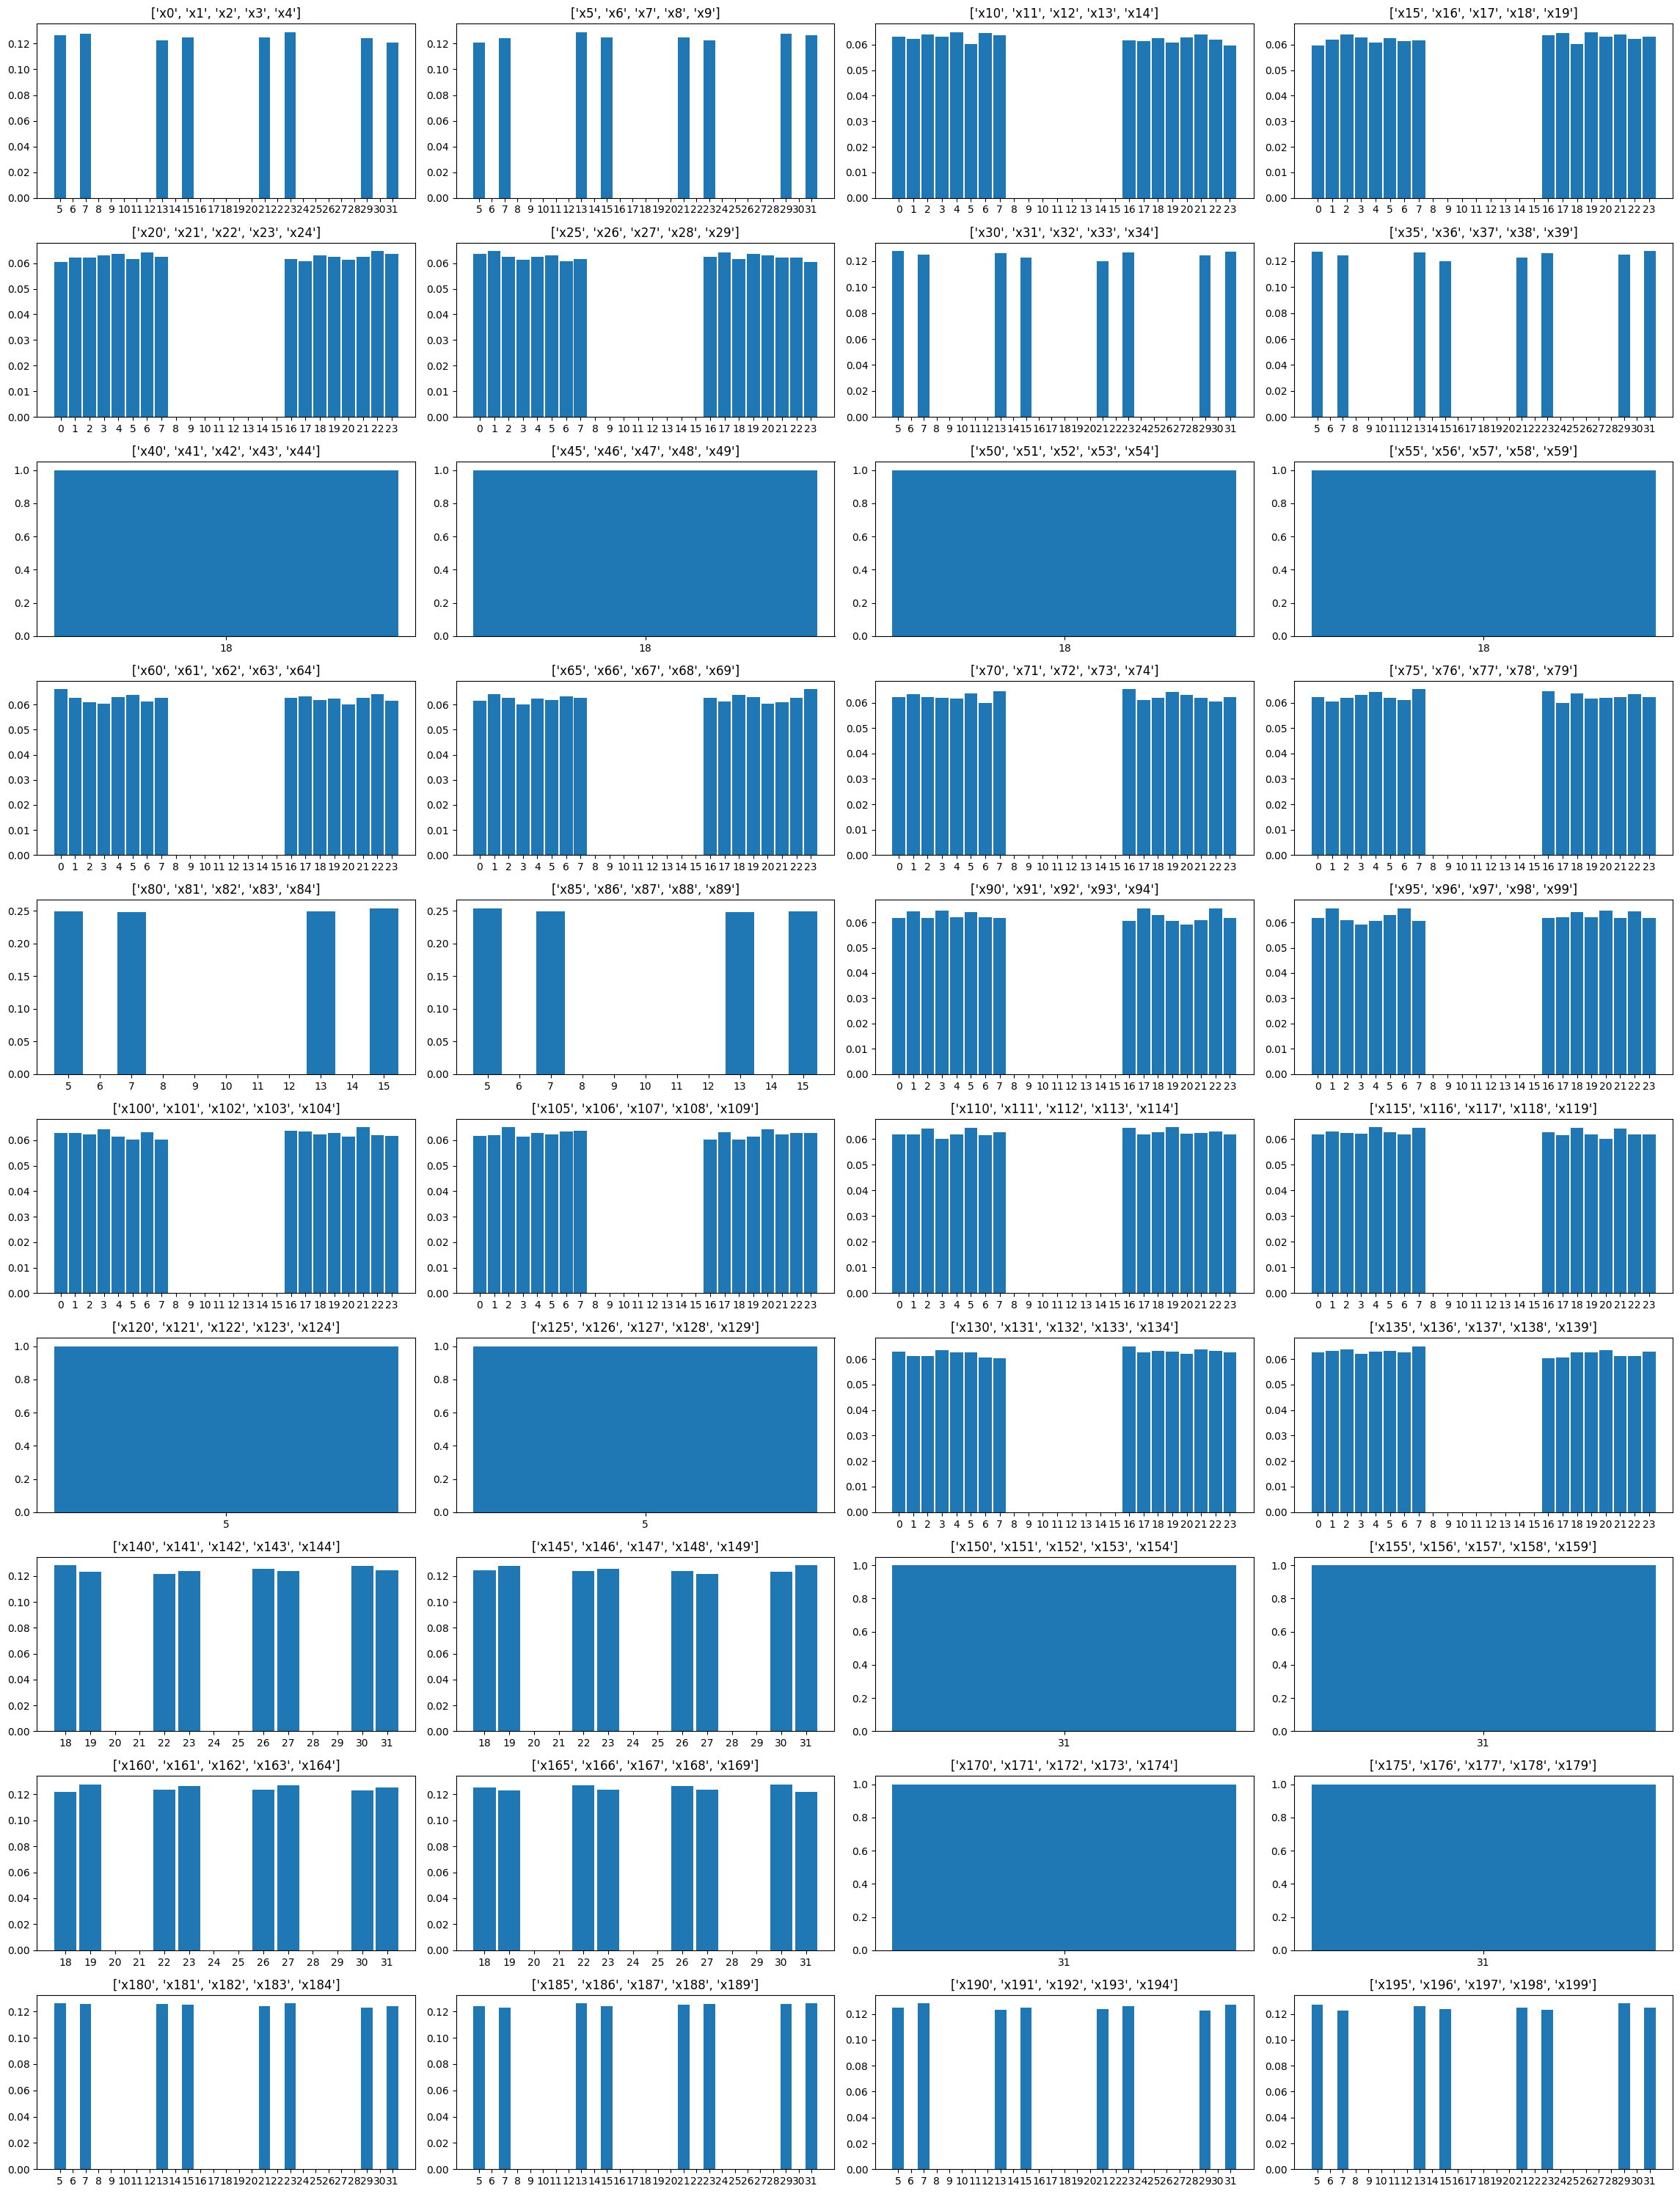

In [93]:
plot_posterior_haplotype = lambda var_names, ax: az.plot_dist(np.array(list(map(lambda x: int("".join(str(y) for y in x),2),trace.posterior[var_names].to_array().values.reshape(5,-1).T))),ax=ax)

num_vars = 200
num_haplotype_vars = int(num_vars/5)
num_rows = int(num_haplotype_vars/4)
size_y   = 3*num_rows

fig, axs_m = plt.subplots(nrows=num_rows, ncols=4, figsize=(23,size_y))
axs = axs_m.ravel()
for i in np.arange(0,num_vars,step=5):
    var_names = [f'x{i+j}' for j in range(5)]
    ax = axs[int(i/5)]
    plot_posterior_haplotype(var_names, ax=ax)
    ax.set_title(var_names)
plt.tight_layout();
# plt.savefig('posterior_haplotypes.png',dpi=150);
plt.show();

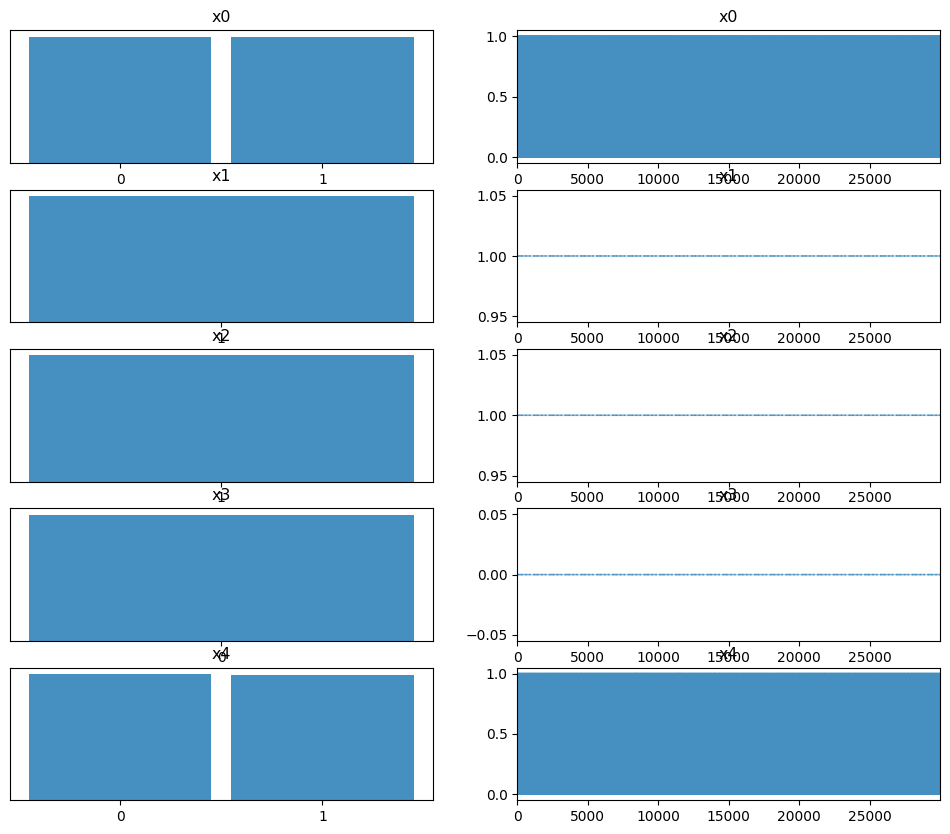

In [72]:
# Plot the posterior
az.plot_trace(trace, var_names=['x0', 'x1', 'x2', 'x3', 'x4']);
plt.savefig('spur_trace_plot_haplotypes.png', dpi=150);

In [86]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.498,0.5,0.0,1.0,0.001,0.001,117983.0,117983.0,1.0
x1,0.492,0.5,0.0,1.0,0.001,0.001,120876.0,120000.0,1.0
x2,1.000,0.0,1.0,1.0,0.000,0.000,120000.0,120000.0,NaN
x3,0.502,0.5,0.0,1.0,0.001,0.001,116846.0,116846.0,1.0
x4,1.000,0.0,1.0,1.0,0.000,0.000,120000.0,120000.0,NaN
...,...,...,...,...,...,...,...,...,...
x995,1.000,0.0,1.0,1.0,0.000,0.000,120000.0,120000.0,NaN
x996,0.500,0.5,0.0,1.0,0.001,0.001,121104.0,120000.0,1.0
x997,0.500,0.5,0.0,1.0,0.001,0.001,119750.0,119750.0,1.0
x998,1.000,0.0,1.0,1.0,0.000,0.000,120000.0,120000.0,NaN
